# FX data

In [1]:
import pandas as pd
import requests
import json
import pprint
import re

In [2]:
import os
from os.path import join
from dotenv import load_dotenv

dotenv_path = join('.env')
load_dotenv(dotenv_path)
AP = os.environ.get("API_KEY")
url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"to_symbol":"JPY",
               #"outputsize":"compact",
               "outputsize":"full",
               "datatype":"json","from_symbol":"USD","function":"FX_DAILY"}

headers = {
    'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
    'x-rapidapi-key': "{}".format(AP)
    }

response = requests.request("GET", url, headers=headers, params=querystring)

In [113]:
d  = json.loads(response.text)
d_ext = d['Time Series FX (Daily)']
s_ext = json.dumps(d_ext)
df0= pd.read_json(s_ext).T.sort_index().reset_index()
df0.columns=['Date','Open','High','Low','Close']
df0.set_index('Date', inplace=True)
df0['Volume']=1

df0=pd.merge(df0.loc[:,'Close'], df0.loc[:,['Open','High','Low','Volume']], left_index=True, right_index=True)

In [114]:
df0.tail(5)

,Close,Open,High,Low,Volume
Date,,,,,
2021-01-05,102.697,103.105,103.191,102.57,1
2021-01-06,103.014,102.706,103.444,102.56,1
2021-01-07,103.777,103.011,103.957,102.92,1
2021-01-08,103.880,103.765,104.094,103.57,1
2021-01-11,104.133,104.088,104.204,104.00,1


<AxesSubplot:xlabel='Date'>

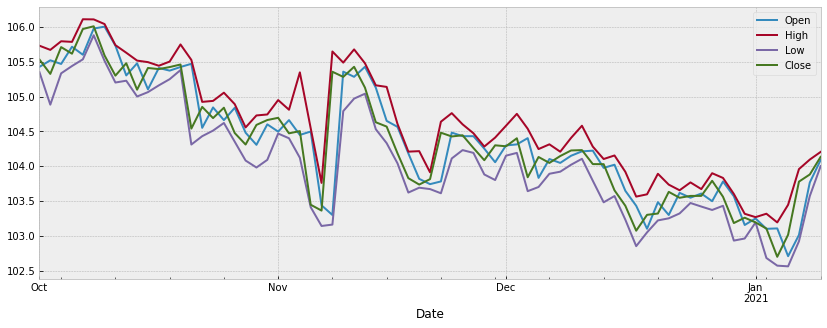

In [115]:
df0[df0.index>='2020-10-01'].plot(y=['Open','High','Low','Close'],figsize=(14,5))

# Forecasting

In [272]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [280]:
## Technical Indicators

# Adding all the indicators
df0 = ta.add_all_ta_features(df0, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
# df0.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

/opt/conda/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/conda/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [366]:
df = df0 #.tail(1000) # [df0.index<='2020-12-31'].tail(365)

## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [355]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

          
def validater(n_per_in, n_per_out,df):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]  #  df[-i:-(i-n_per_in+1)] # 

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))
  

In [367]:
# How many periods looking back to learn
n_per_in  = 60
# How many periods to predict
n_per_out = 10
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [369]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh" #"relu" # 

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)
              )
         )

# Hidden layers
layer_maker(n_layers=3, 
            n_nodes=40, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(40, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=100, verbose=1)

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=200, validation_split=0.01,callbacks=[early_stopping])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 60, 90)            64440     
_________________________________________________________________
lstm_89 (LSTM)               (None, 60, 40)            20960     
_________________________________________________________________
lstm_90 (LSTM)               (None, 60, 40)            12960     
_________________________________________________________________
lstm_91 (LSTM)               (None, 60, 40)            12960     
_________________________________________________________________
lstm_92 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                410       
Total params: 124,690
Trainable params: 124,690
Non-trainable params: 0
_______________________________________________

25/25 [==============================] - 7s 282ms/step - loss: 0.0016 - accuracy: 0.2868 - val_loss: 0.0078 - val_accuracy: 0.2600


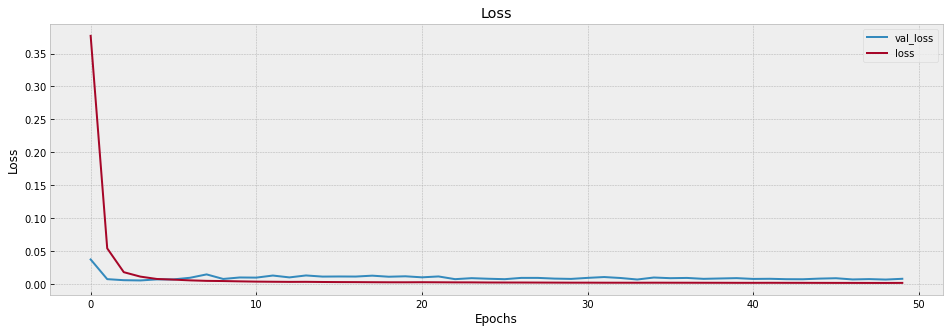

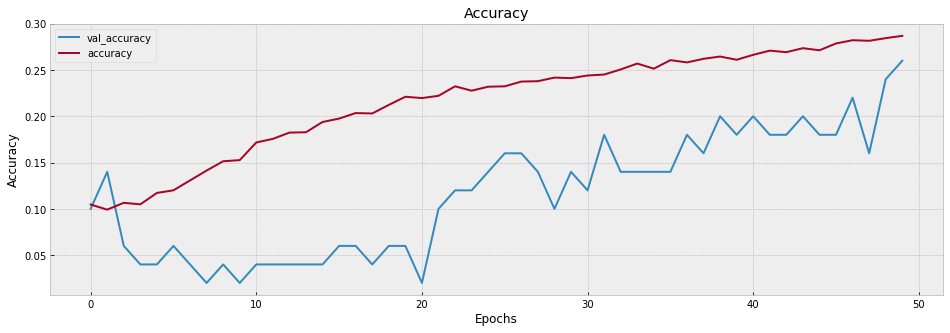

In [370]:
visualize_training_results(res)

RMSE: 0.6938113906718709


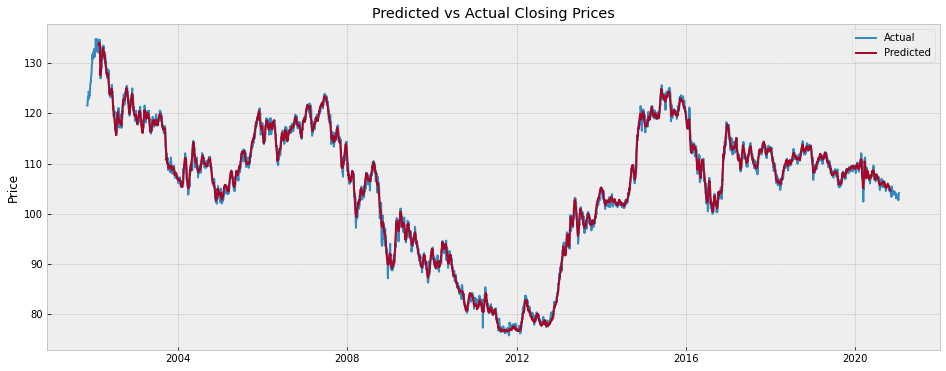

In [371]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out,df)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting the actual values
plt.plot(actual, label='Actual')

# Plotting those predictions
plt.plot(predictions, label='Predicted')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
# plt.xlim('2016-10', '2021-01')
plt.show()

                 Close
2021-01-12  104.123161
2021-01-13  104.224159
2021-01-14  104.369942
2021-01-15  104.559395
2021-01-18  104.807724
2021-01-19  104.888641
2021-01-20  105.047722
2021-01-21  105.196335
2021-01-22  105.240471
2021-01-25  105.350296


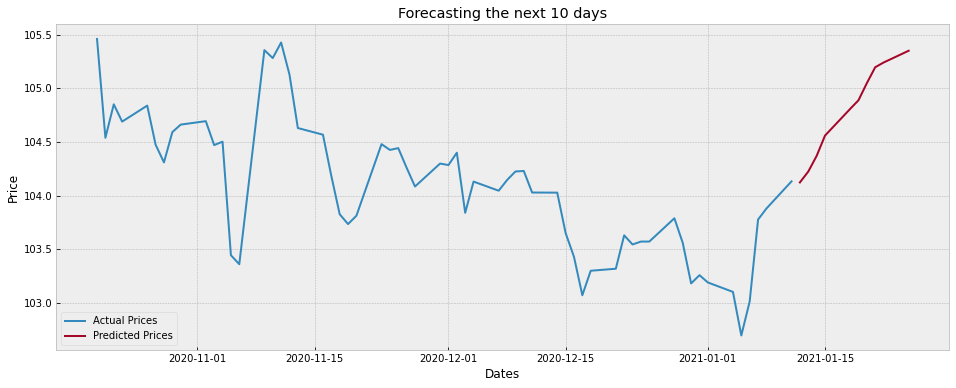

In [372]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = actual.tail(pers)
# actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
#                       index=df.Close.tail(pers).index, 
#                       columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()